In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

np.random.seed(1)

# Little boilerplate code to find out if we have a gpu
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
print(f'Device: {device}')

Cuda installed! Running on GPU!
Device: cuda


## Self-supervised Seismic Event Classification

It is a seismic event waveform
The data and label shapes are: (1000, 6000) (1000,)


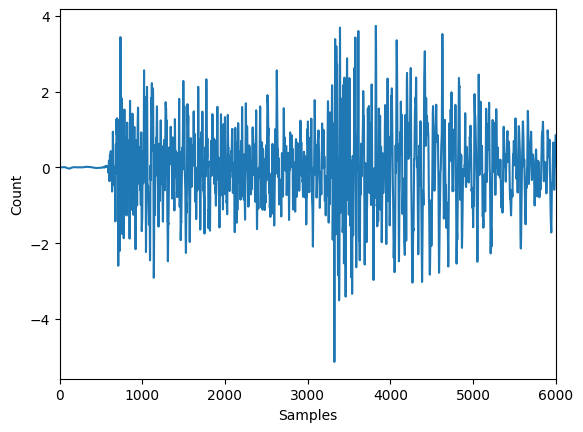

In [2]:
# Loading data
Seismic_Data = np.load('./data/SeismicEvents_Classification/SiesmicEventsClassification_Normalized.npz')
data = Seismic_Data['data']
label = Seismic_Data['label']

# Compute the absolute maximum for each sample along axis 1
#abs_max = np.max(np.abs(data1), axis=1, keepdims=True)
# Normalize each sample by its absolute maximum
#data = data1 / abs_max

#Ploting an example
fig = plt.plot()
k = 97
plt.plot(data[k])
plt.xlim([0,len(data[k])])
plt.xlabel('Samples')
plt.ylabel('Count')

# Checking the label
if label[k]==0:
    print('It is a noise waveform')
else:
    print('It is a seismic event waveform')
    
print('The data and label shapes are:',data.shape,label.shape)


## Data preparation

In [3]:
from torch.utils.data import Dataset, DataLoader

# 1. Define your Dataset class (if you haven't already):

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to torch tensor
        self.labels = torch.tensor(labels, dtype=torch.float32) #Convert labels to long for classification

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [4]:
from sklearn.model_selection import train_test_split

batch_size = 8
# data and labels to tensor
datainput = torch.tensor(data,dtype=torch.float32)
labelout = torch.tensor(label,dtype=torch.float32)


# Divide the data into train and test
train_data, test_data, train_labels, test_labels = train_test_split(
    datainput, labelout, test_size=0.1, random_state=42)

# Create your Dataset instance
dataset_train = MyDataset(train_data, train_labels)
dataset_test  = MyDataset(test_data, test_labels)

# Create a DataLoader
# Adjust batch_size as needed; shuffle=True for training

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=dataset_test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

/tmp/ipykernel_4011255/1364125503.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)  # Convert to torch tensor
/tmp/ipykernel_4011255/1364125503.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.float32) #Convert labels to long for classification


## CNN for Classification

In [5]:
import torch
import torch.nn as nn

class Conv1DCNN(nn.Module):
    def __init__(self, input_channels, FM1, FM2, bottleneck_dim, NN, sequence_length):
        super(Conv1DCNN, self).__init__()
        
        # Encoder
        self.encoder_conv1 = nn.Conv1d(input_channels, FM1, kernel_size=3, stride=1, padding=1)
        self.encoder_ac1 = nn.LeakyReLU(0.5)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)  # Max pooling for downsampling
        
        self.encoder_conv2 = nn.Conv1d(FM1, FM2, kernel_size=3, stride=1, padding=1)
        self.encoder_ac2 = nn.LeakyReLU(0.5)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)  # Max pooling for downsampling
        
        self.encoder_bottleneck = nn.Conv1d(FM2, bottleneck_dim, kernel_size=3, stride=1, padding=1)
        self.encoder_bottleneck_ac = nn.LeakyReLU(0.5)
        
        # Calculate the size after all encoding layers
        # The input sequence length is reduced twice (due to pooling)
        reduced_length = sequence_length // 4  # 2 poolings: 4=2^2
        self.flattened_size = bottleneck_dim * reduced_length
        
        # Classification head
        self.fc1 = nn.Linear(self.flattened_size, NN)  # Adjust the input size as per your bottleneck output
        self.fc_ac1 = nn.LeakyReLU(0.5)
        self.fc2 = nn.Linear(NN, 1)  # Outputting a single value for binary classification
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary classification

    def forward(self, x):
        # Encoding
        E1 = self.encoder_conv1(x)
        E1 = self.encoder_ac1(E1)
        E1 = self.pool1(E1)  # Apply max pooling
        
        E2 = self.encoder_conv2(E1)
        E2 = self.encoder_ac2(E2)
        E2 = self.pool2(E2)  # Apply max pooling
        
        # Bottle-neck
        E3 = self.encoder_bottleneck(E2)
        E3 = self.encoder_bottleneck_ac(E3)
        
        # Preparing for classification
        # Flatten the feature maps
        E3_flat = E3.view(E3.size(0), -1)
        
        # Classification
        out = self.fc1(E3_flat)
        out = self.fc_ac1(out)
        out = self.fc2(out)
        out = self.sigmoid(out)  # Apply sigmoid to get probabilities
        
        return out

In [6]:
sequence_length = 6000
input_channels = 1
FM1 = 4
FM2 = 8
bottleneck_dim = 16
NN = 128

model = Conv1DCNN(input_channels, FM1, FM2, bottleneck_dim, NN, sequence_length).to(device)
print(model)


criterion = nn.BCELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
model.train()
num_epochs = 100
# Threshold
TH = 0.5

for epoch in range(num_epochs):
    # Calculate Accuracy         
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 1,6000).requires_grad_(True).to(device)
        labels = labels.view(-1, 1).to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        # Get predictions from the maximum value
        predicted = np.where(outputs.detach().cpu().numpy() > TH, 1, 0)
        
        # Total number of labels
        total += labels.shape[0]

        # Total correct predictions
        correct += (predicted == labels.cpu()).sum()
            
    accuracy = 100 * correct / total
    
            
    # Print Loss
    print('epoch: {}. Loss: {}. Training Accuracy: {}'.format(epoch, loss.item(), accuracy))
    
    # Early Stopping
    if accuracy>99:
        print('Training Accuracy>99')
        break
    


Conv1DCNN(
  (encoder_conv1): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_ac1): LeakyReLU(negative_slope=0.5)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_ac2): LeakyReLU(negative_slope=0.5)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_bottleneck): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_bottleneck_ac): LeakyReLU(negative_slope=0.5)
  (fc1): Linear(in_features=24000, out_features=128, bias=True)
  (fc_ac1): LeakyReLU(negative_slope=0.5)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
epoch: 0. Loss: 0.19699415564537048. Training Accuracy: 80.77777862548828
epoch: 1. Loss: 0.07948334515094757. Training Accuracy: 93.77777862548828
epoch: 2. Loss: 0.07322221994400024. Training Accuracy: 94.88888549804688
epoch: 3. Loss: 

## Inference (Testing)

In [7]:

correct = 0
total = 0
laball = []
preall = []
# Iterate through test dataset
for images, labels in test_loader:
    # Load images with gradient accumulation capabilities
    images = images.view(-1, 1, 6000).requires_grad_(True).to(device)
    labels = labels.view(-1, 1).to(device)
        
    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    predicted = np.where(outputs.detach().cpu().numpy() > TH, 1, 0)

    # Total number of labels
    total += labels.shape[0]

    # Total correct predictions
    correct += (predicted == labels.cpu()).sum()
    
    laball.append(labels.cpu().numpy()[:,0])
    preall.append(predicted[:,0])

accuracy = 100 * correct / total

# Print Loss
print('Loss: {}. Testing Accuracy: {}'.format(loss.item(), accuracy))

Loss: 0.01709488220512867. Testing Accuracy: 96.0


It is a seismic event waveform, and the prediction is: 1


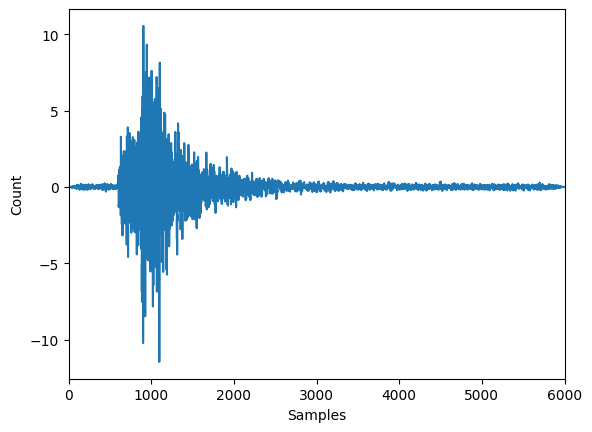

In [8]:
#Ploting an example
k = 0
plt.plot(images[k][0,:].detach().cpu().numpy())
plt.xlim([0,len(images[k][0,:])])
plt.xlabel('Samples')
plt.ylabel('Count')

# Checking the label
if labels[k]==0:
    print('It is a noise waveform,', 'and the prediction is:', predicted[k][0])
else:
    print('It is a seismic event waveform,' , 'and the prediction is:', predicted[k][0])
    


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Example data (replace with your actual data)
y_true = np.array(np.concatenate(laball),dtype=np.int32)  # True labels (0: negative, 1: positive)
y_pred = np.array(np.concatenate(preall))  # Predicted labels

# 1. Confusion Matrix:

cm = confusion_matrix(y_true, y_pred,labels=[0,1])
tp, fp, fn, tn = cm.ravel() #This line gets tp, fp, fn, tn directly from confusion matrix
print("Confusion Matrix:\n", cm)
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}") #Explicit labels for clarity

# 2. Accuracy:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# 3. Precision:
precision = precision_score(y_true, y_pred)
print(f"Precision: {precision:.2f}")

# 4. Recall:
recall = recall_score(y_true, y_pred)
print(f"Recall: {recall:.2f}")

# 5. F1-score:
f1 = f1_score(y_true, y_pred)
print(f"F1-score: {f1:.2f}")

Confusion Matrix:
 [[50  0]
 [ 4 46]]
TN: 46, FP: 0, FN: 4, TP: 50
Accuracy: 0.96
Precision: 1.00
Recall: 0.92
F1-score: 0.96


## Autoencoder

In [10]:
from sklearn.model_selection import train_test_split

batch_size = 8
# data and labels to tensor
datainput = torch.tensor(data,dtype=torch.float32)
labelout = torch.tensor(label,dtype=torch.float32)


# Divide the data into train and test
train_data, test_data, train_labels, test_labels = train_test_split(
    datainput, datainput, test_size=0.1, random_state=42)

# Create your Dataset instance
dataset_train = MyDataset(train_data, train_labels)
dataset_test  = MyDataset(test_data, test_labels)

# Create a DataLoader
# Adjust batch_size as needed; shuffle=True for training

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=dataset_test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

/tmp/ipykernel_4011255/1364125503.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)  # Convert to torch tensor
/tmp/ipykernel_4011255/1364125503.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.float32) #Convert labels to long for classification


In [11]:
import torch
import torch.nn as nn

class Conv1DAutoencoder(nn.Module):
    def __init__(self, input_channels, FM1, FM2, bottleneck_dim, output_channels):
        super(Conv1DAutoencoder, self).__init__()
        
        # Encoder
        self.encoder_conv1 = nn.Conv1d(input_channels, FM1, kernel_size=3, stride=1, padding=1)
        self.encoder_ac1 = nn.LeakyReLU(0.5)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)  # Max pooling for downsampling
        
        self.encoder_conv2 = nn.Conv1d(FM1, FM2, kernel_size=3, stride=1, padding=1)
        self.encoder_ac2 = nn.LeakyReLU(0.5)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)  # Max pooling for downsampling
        
        self.encoder_bottleneck = nn.Conv1d(FM2, bottleneck_dim, kernel_size=3, stride=1, padding=1)
        self.encoder_bottleneck_ac = nn.LeakyReLU(0.5)

        # Decoder
        self.decoder_upsample1 = nn.Upsample(scale_factor=2, mode='linear')  # 1D upsampling
        self.decoder_conv1 = nn.Conv1d(bottleneck_dim, FM2, kernel_size=3, padding=1)
        self.decoder_ac1 = nn.LeakyReLU(0.5)
        
        self.decoder_upsample2 = nn.Upsample(scale_factor=2, mode='linear')  # 1D upsampling
        self.decoder_conv2 = nn.Conv1d(FM2, FM1, kernel_size=3, padding=1)
        self.decoder_ac2 = nn.LeakyReLU(0.5)
        
        self.decoder_conv3 = nn.Conv1d(FM1, output_channels, kernel_size=3, padding=1)  # No upsample layer here

    def forward(self, x):
        # Encoding
        E1 = self.encoder_conv1(x)
        E1 = self.encoder_ac1(E1)
        E1 = self.pool1(E1)  # Apply max pooling
        
        E2 = self.encoder_conv2(E1)
        E2 = self.encoder_ac2(E2)
        E2 = self.pool2(E2)  # Apply max pooling
        
        # Bottle-neck
        E3 = self.encoder_bottleneck(E2)
        E3 = self.encoder_bottleneck_ac(E3)
        
        # Decoding
        D1 = self.decoder_upsample1(E3)  # Upsampling
        D1 = self.decoder_conv1(D1)
        D1 = self.decoder_ac1(D1)
        
        D2 = self.decoder_upsample2(D1)  # Upsampling
        D2 = self.decoder_conv2(D2)
        D2 = self.decoder_ac2(D2)
        
        out = self.decoder_conv3(D2)  # No additional upsample layer before final output
        
        return E3, out


In [12]:

input_channels = 1
FM1 = 4
FM2 = 8
bottleneck_dim = 16
output_channels = 1

model = Conv1DAutoencoder(input_channels, FM1, FM2, bottleneck_dim, output_channels).to(device)
print(model)


criterion = nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
model.train()
num_epochs = 100

for epoch in range(num_epochs):
    losall = 0
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 1,6000).requires_grad_(True).to(device)
        labels = labels.view(-1, 1,6000).to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        E, outputs = model(images)
        
        # Calculate Loss
        loss = criterion(outputs, labels)
        losall+=loss.item()
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
    
            
    # Print Loss
    print('epoch: {}. Loss: {}'.format(epoch, losall))
    


Conv1DAutoencoder(
  (encoder_conv1): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_ac1): LeakyReLU(negative_slope=0.5)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_ac2): LeakyReLU(negative_slope=0.5)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_bottleneck): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_bottleneck_ac): LeakyReLU(negative_slope=0.5)
  (decoder_upsample1): Upsample(scale_factor=2.0, mode='linear')
  (decoder_conv1): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (decoder_ac1): LeakyReLU(negative_slope=0.5)
  (decoder_upsample2): Upsample(scale_factor=2.0, mode='linear')
  (decoder_conv2): Conv1d(8, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (decoder_ac2): LeakyReLU(negative_slope=0.5)
  (decoder_conv3): Conv1d(4, 1, kernel_siz

In [13]:
laball = []
dat = []
outputsall= []
Eall = []
# Iterate through test dataset
for images, labels in test_loader:
    # Load images with gradient accumulation capabilities
    images = images.view(-1, 1,6000).requires_grad_(True).to(device)
    labels = labels.view(-1, 1,6000).to(device)
        
    # Forward pass only to get logits/output
    E, outputs = model(images)

    
    laball.append(labels.cpu().numpy())
    dat.append(images.detach().cpu().numpy())
    outputsall.append(outputs.detach().cpu().numpy())
    Eall.append(E.detach().cpu().numpy())

    

outputsall = np.concatenate(outputsall)
laball = np.concatenate(laball)
dat = np.concatenate(dat)
Eall = np.concatenate(Eall)

# Print Loss
print('Loss: {}'.format(loss.item()))

Loss: 0.15348848700523376


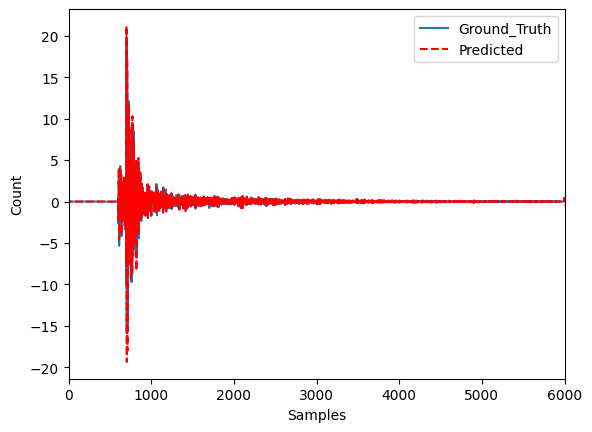

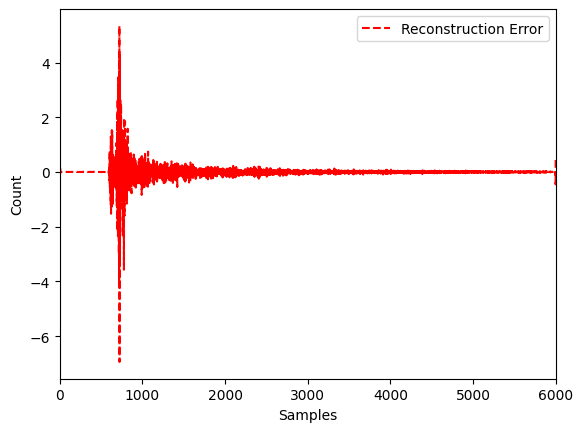

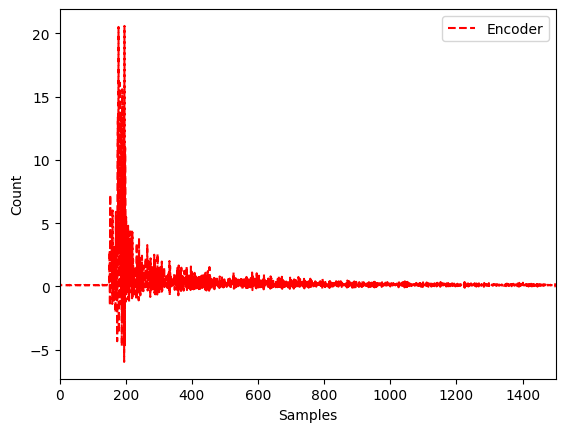

In [14]:
#Ploting an example
k = 20
X = dat[k][0]
Y = laball[k][0]
Z = outputsall[k][0]
Q = Eall[k][0]

plt.figure()
plt.plot(X,label='Ground_Truth')
plt.xlim([0,len(X)])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(Z, color='r', linestyle='--', label='Predicted')
plt.legend()

plt.figure()
plt.xlim([0,len(X)])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(X-Z, color='r', linestyle='--', label='Reconstruction Error')
plt.legend()


plt.figure()
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(Q, color='r', linestyle='--', label='Encoder')
plt.xlim([0,len(Q)])
plt.legend()

## Deep Autoencoder

In [15]:
import torch
import torch.nn as nn

class DeepConv1DAutoencoder(nn.Module):
    def __init__(self, input_channels, FM1, FM2, FM3, bottleneck_dim, output_channels):
        super(DeepConv1DAutoencoder, self).__init__()
        
        # Encoder
        self.encoder_conv1 = nn.Conv1d(input_channels, FM1, kernel_size=3, stride=1, padding=1)
        self.encoder_ac1 = nn.LeakyReLU(0.5)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder_conv2 = nn.Conv1d(FM1, FM1, kernel_size=3, stride=1, padding=1)  # Same feature maps
        self.encoder_ac2 = nn.LeakyReLU(0.5)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder_conv3 = nn.Conv1d(FM1, FM2, kernel_size=3, stride=1, padding=1)
        self.encoder_ac3 = nn.LeakyReLU(0.5)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder_conv4 = nn.Conv1d(FM2, FM3, kernel_size=3, stride=1, padding=1)
        self.encoder_ac4 = nn.LeakyReLU(0.5)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder_bottleneck = nn.Conv1d(FM3, bottleneck_dim, kernel_size=3, stride=1, padding=1)  # Bottleneck with 1 feature map
        self.encoder_bottleneck_ac = nn.LeakyReLU(0.5)

        # Decoder
        self.decoder_upsample1 = nn.Upsample(scale_factor=2, mode='linear')
        self.decoder_conv1 = nn.Conv1d(bottleneck_dim, FM3, kernel_size=3, padding=1)
        self.decoder_ac1 = nn.LeakyReLU(0.5)

        self.decoder_upsample2 = nn.Upsample(scale_factor=2, mode='linear')
        self.decoder_conv2 = nn.Conv1d(FM3, FM2, kernel_size=3, padding=1)
        self.decoder_ac2 = nn.LeakyReLU(0.5)

        self.decoder_upsample3 = nn.Upsample(scale_factor=2, mode='linear')
        self.decoder_conv3 = nn.Conv1d(FM2, FM1, kernel_size=3, padding=1)
        self.decoder_ac3 = nn.LeakyReLU(0.5)

        self.decoder_upsample4 = nn.Upsample(scale_factor=2, mode='linear')
        self.decoder_conv4 = nn.Conv1d(FM1, FM1, kernel_size=3, padding=1)
        self.decoder_ac4 = nn.LeakyReLU(0.5)

        self.decoder_convF = nn.Conv1d(FM1, output_channels, kernel_size=3, padding=1)  # Final output layer

    def forward(self, x):
        # Encoding
        E1 = self.encoder_conv1(x)
        E1 = self.encoder_ac1(E1)
        P1 = self.pool1(E1)

        E2 = self.encoder_conv2(P1)
        E2 = self.encoder_ac2(E2)
        P2 = self.pool2(E2)

        E3 = self.encoder_conv3(P2)
        E3 = self.encoder_ac3(E3)
        P3 = self.pool3(E3)

        E4 = self.encoder_conv4(P3)
        E4 = self.encoder_ac4(E4)
        P4 = self.pool4(E4)

        # Bottleneck
        E5 = self.encoder_bottleneck(P4)
        E5 = self.encoder_bottleneck_ac(E5)

        # Decoding
        D1 = self.decoder_upsample1(E5)
        D1 = self.decoder_conv1(D1)
        D1 = self.decoder_ac1(D1)

        D2 = self.decoder_upsample2(D1)
        D2 = self.decoder_conv2(D2)
        D2 = self.decoder_ac2(D2)

        D3 = self.decoder_upsample3(D2)
        D3 = self.decoder_conv3(D3)
        D3 = self.decoder_ac3(D3)

        D4 = self.decoder_upsample4(D3)
        D4 = self.decoder_conv4(D4)
        D4 = self.decoder_ac4(D4)
        
        out = self.decoder_convF(D4)  # Final output layer
        
        return E5, out

In [16]:

input_channels = 1
FM1 = 4
FM2 = 8
FM3 = 16
bottleneck_dim = 32
output_channels = 1

model = DeepConv1DAutoencoder(input_channels, FM1, FM2, FM3, bottleneck_dim, output_channels).to(device)
print(model)


criterion = nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
model.train()
num_epochs = 100

for epoch in range(num_epochs):
    losall = 0
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 1,6000).requires_grad_(True).to(device)
        labels = labels.view(-1, 1,6000).to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        E, outputs = model(images)
        
        # Calculate Loss
        loss = criterion(outputs, labels)
        losall+=loss.item()
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
    
            
    # Print Loss
    print('epoch: {}. Loss: {}'.format(epoch, losall))
    


DeepConv1DAutoencoder(
  (encoder_conv1): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_ac1): LeakyReLU(negative_slope=0.5)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_ac2): LeakyReLU(negative_slope=0.5)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv3): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_ac3): LeakyReLU(negative_slope=0.5)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv4): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_ac4): LeakyReLU(negative_slope=0.5)
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_bottleneck): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_bottleneck_ac): LeakyReLU(negative_slope=

In [17]:
laball = []
dat = []
outputsall= []
Eall = []
# Iterate through test dataset
for images, labels in test_loader:
    # Load images with gradient accumulation capabilities
    images = images.view(-1, 1,6000).requires_grad_(True).to(device)
    labels = labels.view(-1, 1,6000).to(device)
        
    # Forward pass only to get logits/output
    E, outputs = model(images)

    
    laball.append(labels.cpu().numpy())
    dat.append(images.detach().cpu().numpy())
    outputsall.append(outputs.detach().cpu().numpy())
    Eall.append(E.detach().cpu().numpy())

    

outputsall = np.concatenate(outputsall)
laball = np.concatenate(laball)
dat = np.concatenate(dat)
Eall = np.concatenate(Eall)

# Print Loss
print('Loss: {}'.format(loss.item()))

Loss: 0.5291943550109863


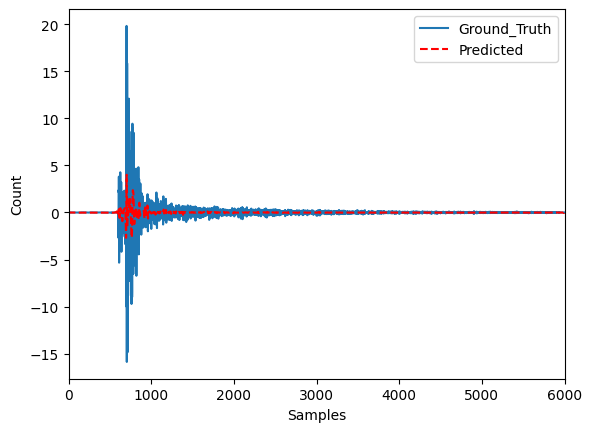

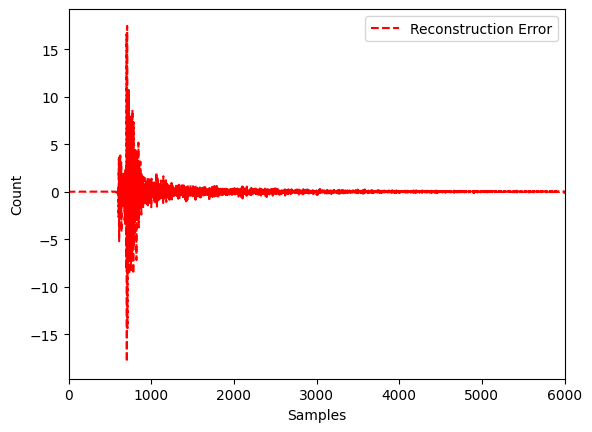

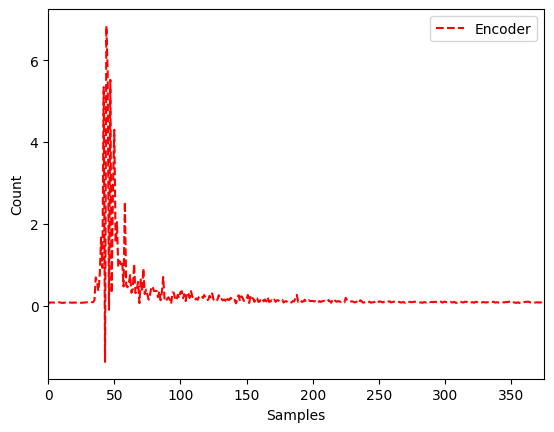

In [18]:
#Ploting an example
k = 20
X = dat[k][0]
Y = laball[k][0]
Z = outputsall[k][0]
Q = Eall[k][0]

plt.figure()
plt.plot(X,label='Ground_Truth')
plt.xlim([0,len(X)])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(Z, color='r', linestyle='--', label='Predicted')
plt.legend()

plt.figure()
plt.xlim([0,len(X)])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(X-Z, color='r', linestyle='--', label='Reconstruction Error')
plt.legend()


plt.figure()
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(Q, color='r', linestyle='--', label='Encoder')
plt.xlim([0,len(Q)])
plt.legend()

## UNET

In [19]:
class UNET(nn.Module):
    def __init__(self, input_channels, FM1, FM2, FM3, bottleneck_dim, output_channels):
        super(UNET, self).__init__()
        
        # Encoder
        self.encoder_conv1 = nn.Conv1d(input_channels, FM1, kernel_size=3, stride=1, padding=1)
        self.encoder_ac1 = nn.LeakyReLU(0.5)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder_conv2 = nn.Conv1d(FM1, FM1, kernel_size=3, stride=1, padding=1)  # Same feature maps
        self.encoder_ac2 = nn.LeakyReLU(0.5)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder_conv3 = nn.Conv1d(FM1, FM2, kernel_size=3, stride=1, padding=1)
        self.encoder_ac3 = nn.LeakyReLU(0.5)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder_conv4 = nn.Conv1d(FM2, FM3, kernel_size=3, stride=1, padding=1)
        self.encoder_ac4 = nn.LeakyReLU(0.5)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder_bottleneck = nn.Conv1d(FM3, bottleneck_dim, kernel_size=3, stride=1, padding=1)  # Bottleneck with 1 feature map
        self.encoder_bottleneck_ac = nn.LeakyReLU(0.5)

        # Decoder
        self.decoder_upsample1 = nn.Upsample(scale_factor=2, mode='linear')
        self.decoder_conv1 = nn.Conv1d(bottleneck_dim, FM3, kernel_size=3, padding=1)
        self.decoder_ac1 = nn.LeakyReLU(0.5)

        self.decoder_upsample2 = nn.Upsample(scale_factor=2, mode='linear')
        self.decoder_conv2 = nn.Conv1d(FM3, FM2, kernel_size=3, padding=1)
        self.decoder_ac2 = nn.LeakyReLU(0.5)

        self.decoder_upsample3 = nn.Upsample(scale_factor=2, mode='linear')
        self.decoder_conv3 = nn.Conv1d(FM2, FM1, kernel_size=3, padding=1)
        self.decoder_ac3 = nn.LeakyReLU(0.5)

        self.decoder_upsample4 = nn.Upsample(scale_factor=2, mode='linear')
        self.decoder_conv4 = nn.Conv1d(FM1, FM1, kernel_size=3, padding=1)
        self.decoder_ac4 = nn.LeakyReLU(0.5)

        self.decoder_convF = nn.Conv1d(FM1, output_channels, kernel_size=3, padding=1)  # Final output layer

    def forward(self, x):
        # Encoding
        E1 = self.encoder_conv1(x)
        E1 = self.encoder_ac1(E1)
        P1 = self.pool1(E1)

        E2 = self.encoder_conv2(P1)
        E2 = self.encoder_ac2(E2)
        P2 = self.pool2(E2)

        E3 = self.encoder_conv3(P2)
        E3 = self.encoder_ac3(E3)
        P3 = self.pool3(E3)

        E4 = self.encoder_conv4(P3)
        E4 = self.encoder_ac4(E4)
        P4 = self.pool4(E4)

        # Bottleneck
        E5 = self.encoder_bottleneck(P4)
        E5 = self.encoder_bottleneck_ac(E5)

        # Decoding
        D1 = self.decoder_upsample1(E5)
        D1 = self.decoder_conv1(D1)
        D1 = self.decoder_ac1(D1)
        D1 = D1 + E4  # Skip connection

        D2 = self.decoder_upsample2(D1)
        D2 = self.decoder_conv2(D2)
        D2 = self.decoder_ac2(D2)
        D2 = D2 + E3  # Skip connection

        D3 = self.decoder_upsample3(D2)
        D3 = self.decoder_conv3(D3)
        D3 = self.decoder_ac3(D3)
        D3 = D3 + E2  # Skip connection

        D4 = self.decoder_upsample4(D3)
        D4 = self.decoder_conv4(D4)
        D4 = self.decoder_ac4(D4)
        D4 = D4 + E1  # Skip connection
        
        out = self.decoder_convF(D4)  # Final output layer
        
        return E5, out

In [20]:

input_channels = 1
FM1 = 4
FM2 = 8
FM3 = 16
bottleneck_dim = 32
output_channels = 1

model = UNET(input_channels, FM1, FM2, FM3, bottleneck_dim, output_channels).to(device)
print(model)


criterion = nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
model.train()
num_epochs = 100

for epoch in range(num_epochs):
    losall = 0
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 1,6000).requires_grad_(True).to(device)
        labels = labels.view(-1, 1,6000).to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        E, outputs = model(images)
        
        # Calculate Loss
        loss = criterion(outputs, labels)
        losall+=loss.item()
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
    
            
    # Print Loss
    print('epoch: {}. Loss: {}'.format(epoch, losall))
    


UNET(
  (encoder_conv1): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_ac1): LeakyReLU(negative_slope=0.5)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_ac2): LeakyReLU(negative_slope=0.5)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv3): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_ac3): LeakyReLU(negative_slope=0.5)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv4): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_ac4): LeakyReLU(negative_slope=0.5)
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_bottleneck): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_bottleneck_ac): LeakyReLU(negative_slope=0.5)
  (decoder_u

In [21]:
laball = []
dat = []
outputsall= []
Eall = []
# Iterate through test dataset
for images, labels in test_loader:
    # Load images with gradient accumulation capabilities
    images = images.view(-1, 1,6000).requires_grad_(True).to(device)
    labels = labels.view(-1, 1,6000).to(device)
        
    # Forward pass only to get logits/output
    E, outputs = model(images)

    
    laball.append(labels.cpu().numpy())
    dat.append(images.detach().cpu().numpy())
    outputsall.append(outputs.detach().cpu().numpy())
    Eall.append(E.detach().cpu().numpy())

    

outputsall = np.concatenate(outputsall)
laball = np.concatenate(laball)
dat = np.concatenate(dat)
Eall = np.concatenate(Eall)

# Print Loss
print('Loss: {}'.format(loss.item()))

Loss: 0.0008012802572920918


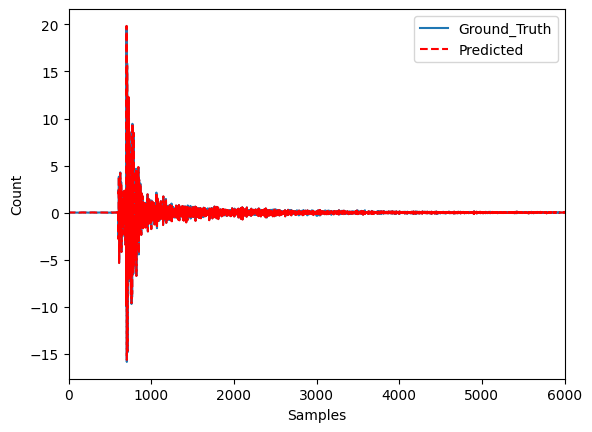

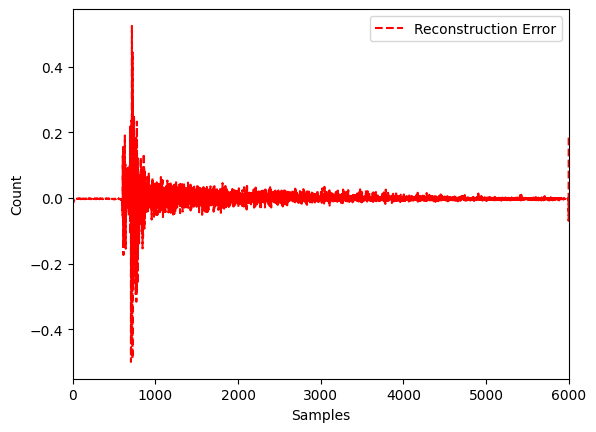

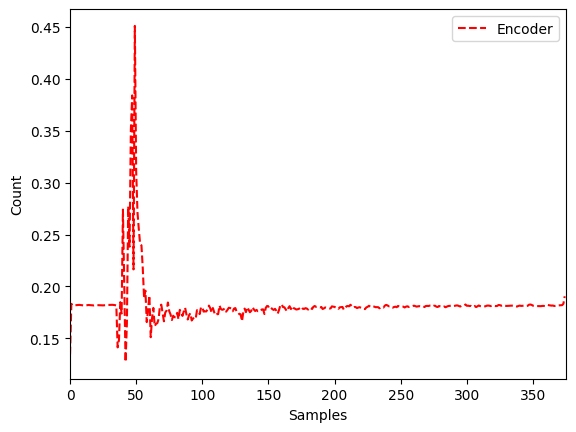

In [22]:
#Ploting an example
k = 20
X = dat[k][0]
Y = laball[k][0]
Z = outputsall[k][0]
Q = Eall[k][0]

plt.figure()
plt.plot(X,label='Ground_Truth')
plt.xlim([0,len(X)])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(Z, color='r', linestyle='--', label='Predicted')
plt.legend()

plt.figure()
plt.xlim([0,len(X)])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(X-Z, color='r', linestyle='--', label='Reconstruction Error')
plt.legend()


plt.figure()
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(Q, color='r', linestyle='--', label='Encoder')
plt.xlim([0,len(Q)])
plt.legend()